In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn import tree
from sklearn.metrics import accuracy_score, mutual_info_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import minmax_scale
from torch.utils.data import Dataset, DataLoader
from termcolor import colored
from tqdm import tqdm

In [2]:
# Load dataset
dataset_zip = np.load('C:/Users/Minh Vu/Downloads/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', 
                      encoding='latin1', allow_pickle=True)

# Get the keys as a list
keys_list = list(dataset_zip.keys())
print("Keys in the dataset:", keys_list)

# Extract data
imgs = dataset_zip['imgs']
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']

# Load metadata
metadata = dataset_zip['metadata'].item()
print('\nMetadata: \n', metadata)

Keys in the dataset: ['metadata', 'imgs', 'latents_classes', 'latents_values']

Metadata: 
 {'date': 'April 2017', 'description': 'Disentanglement test Sprites dataset.Procedurally generated 2D shapes, from 6 disentangled latent factors.This dataset uses 6 latents, controlling the color, shape, scale, rotation and position of a sprite. All possible variations of the latents are present. Ordering along dimension 1 is fixed and can be mapped back to the exact latent values that generated that image.We made sure that the pixel outputs are different. No noise added.', 'version': 1, 'latents_names': ('color', 'shape', 'scale', 'orientation', 'posX', 'posY'), 'latents_possible_values': {'orientation': array([0.        , 0.16110732, 0.32221463, 0.48332195, 0.64442926,
       0.80553658, 0.96664389, 1.12775121, 1.28885852, 1.44996584,
       1.61107316, 1.77218047, 1.93328779, 2.0943951 , 2.25550242,
       2.41660973, 2.57771705, 2.73882436, 2.89993168, 3.061039  ,
       3.22214631, 3.383253

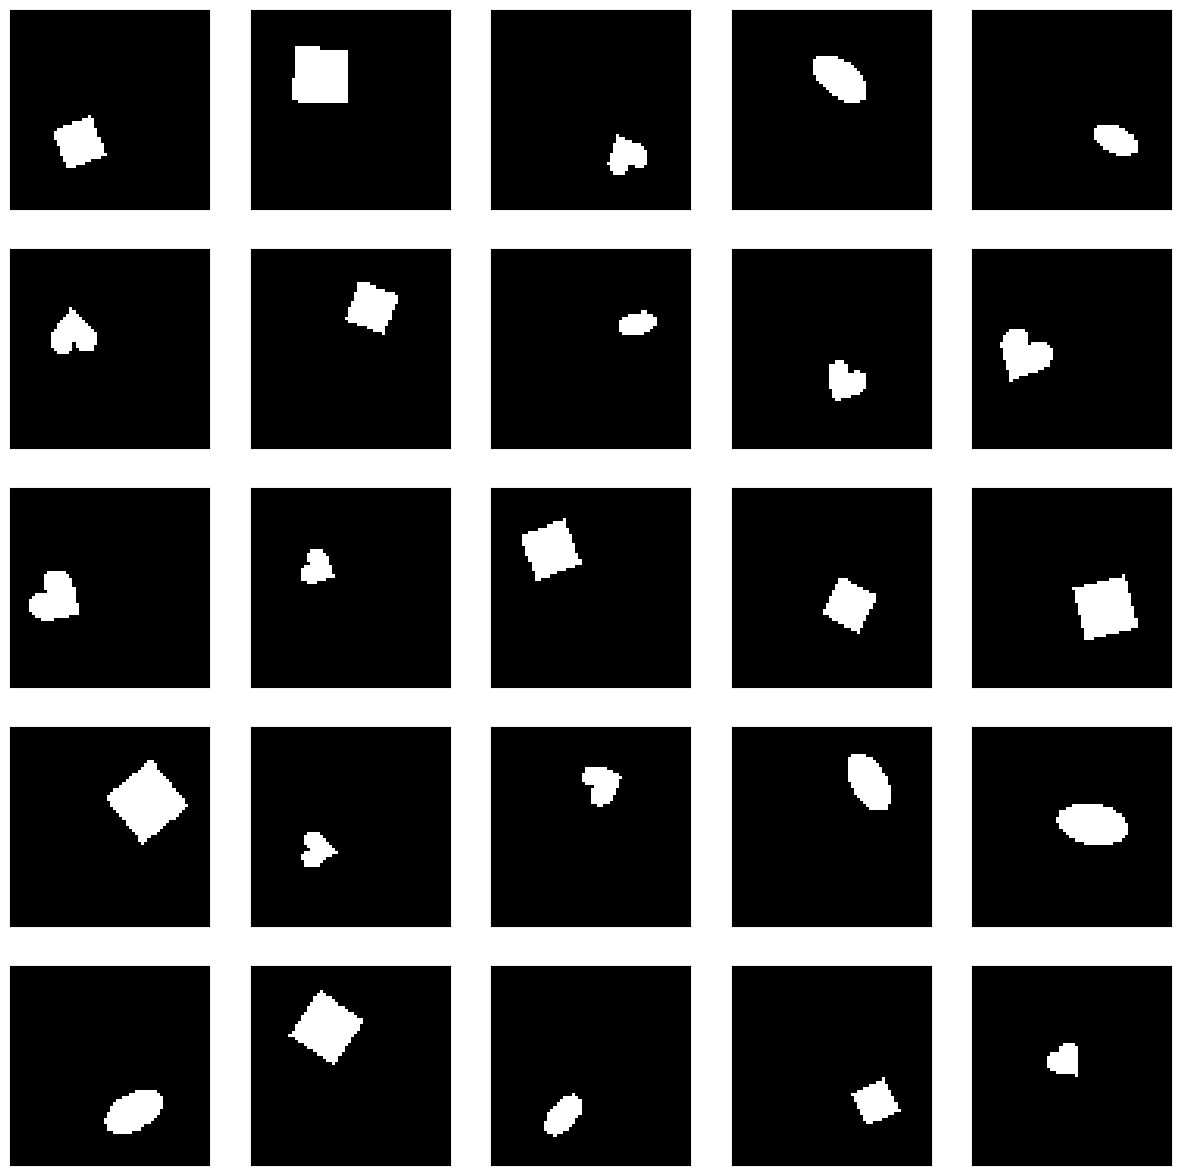

In [3]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata['latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:], np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

# Display images function
def show_images_grid(imgs_, num_images):
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')
    
# Randomly sampling 5000 images from the dataset
factors_sampled = sample_latent(5000)

# Select images
indices_sampled = latent_to_index(factors_sampled)
imgs_sampled = imgs[indices_sampled]

# Show 25 images
show_images_grid(imgs_sampled, 25)

In [4]:
# Custom dataset class for dSprites
class DspritesDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file)
        self.images = np.expand_dims(self.data['imgs'], axis=1)
        self.latent_values = self.data['latents_values']
        self.latent_classes = self.data['latents_classes']

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32)
        latent_values = torch.tensor(self.latent_values[idx], dtype=torch.float32)
        latent_classes = torch.tensor(self.latent_classes[idx], dtype=torch.int)
        return image, latent_values, latent_classes

# VAE Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, output_dim)
        )
        self.fc_mu = nn.Linear(output_dim, latent_dim)
        self.fc_logvar = nn.Linear(output_dim, latent_dim)

    def forward(self, x):
        h = x.view(-1, 64 * 64)
        h = self.fc(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# VAE Decoder
class Decoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        h = self.net(z)
        mu_img = h.view(z.size(0), 1, 64, 64)
        return mu_img

# VAE model
class VAE(nn.Module):
    def __init__(self, input_dim, encoder_output_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, encoder_output_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar, beta):
    # Apply binary cross-entropy loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # Compute the Kullback-Leibler divergence (KLD) term
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Compute ELBO loss
    ELBO = BCE + beta * KLD
    
    return BCE, KLD, ELBO

# Training function
def train_vae(model, data_loader, optimizer, criterion, beta):
    model.train()
    prev_loss = float('inf')

    for epoch in range(NUM_EPOCHS):
        running_recon_loss = 0.0
        running_kl_loss = 0.0
        for image, latent_values, latent_classes in tqdm(data_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS}', unit='batch'):
            image = image.to(DEVICE)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(image)
            recon_loss, kl_loss, elbo = criterion(recon_batch, image, mu, logvar, beta)
            elbo.backward()
            optimizer.step()
            running_recon_loss += recon_loss.item()
            running_kl_loss += kl_loss.item()
        
        # Compute average losses for the epoch
        avg_recon_loss = running_recon_loss / len(data_loader.dataset)
        avg_kl_loss = running_kl_loss / len(data_loader.dataset)
        avg_elbo_loss = round(avg_recon_loss + beta * avg_kl_loss, 4)
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, ELBO: {avg_elbo_loss}")

        # Check for early convergence
        if abs(avg_elbo_loss - prev_loss) < 1e-3:
            break
        
        prev_loss = avg_elbo_loss
    
    return avg_recon_loss, avg_kl_loss, avg_elbo_loss

# Visualization function
def visualize_reconstructions(model, data_loader, num_samples):
    model.eval()
    num_cols = num_samples
    fig, axes = plt.subplots(2, num_cols, figsize=(15, 6))
    
    with torch.no_grad():
        for i, (image, _, _) in enumerate(data_loader):
            if i >= num_samples:
                break
            
            image = image.to(DEVICE)
            recon_batch, _, _ = model(image)
            original_img = image.cpu().numpy().squeeze()
            reconstructed_img = recon_batch.cpu().numpy().squeeze()
            
            # Plot original images
            for j in range(num_cols):
                axes[0, j].imshow(original_img[j], cmap='gray')
                axes[0, j].axis('off')
            
            # Plot reconstructed images
            for j in range(num_cols):
                axes[1, j].imshow(reconstructed_img[j], cmap='gray')
                axes[1, j].axis('off')
            
            plt.show()
            break

In [5]:
def concat_matrix(matrices, num_batches):
    concatenated_matrix = []
    for  i in range(num_batches):
        matrix = matrices[i]
        if i == 0:
            concatenated_matrix = matrix
        else:
            concatenated_matrix = np.concatenate((concatenated_matrix, matrix), axis=0)

    return concatenated_matrix

# Sampling function
def get_factors_latents(model, data_loader):
    model.eval()
    with torch.no_grad():
        all_factor_values = []
        all_factor_classes = []
        all_mu = []
        for image, factor_values, factor_classes in tqdm(data_loader, desc="Extracting Factors and Latents"):
            all_factor_values.append(factor_values)
            all_factor_classes.append(factor_classes)
            image = image.to(DEVICE)
            mu, logvar = model.encoder(image.view(image.size(0), -1))
            all_mu.append(mu.squeeze().cpu().numpy())

    concatenated_factor_values = torch.cat(all_factor_values, dim=0).numpy()
    concatenated_factor_classes = torch.cat(all_factor_classes, dim=0).numpy()
    num_batches = int(DATA_SIZE / BATCH_SIZE)
    concatenated_mu = concat_matrix(np.array(all_mu), num_batches)
    
    return concatenated_factor_values, concatenated_factor_classes, concatenated_mu

In [6]:
def get_bin_index(x, nb_bins):
    # get bins limits
    bins = np.linspace(0, 1, nb_bins + 1)

    # discretize input variable
    return np.digitize(x, bins[:-1], right=False).astype(int)

# MIG score
def mig(factors, latents, nb_bins):
    # count the number of factors and latents
    nb_factors = factors.shape[1]
    nb_latents = latents.shape[1]
    
    # quantize latents
    latents = np.apply_along_axis(minmax_scale, axis=0, arr=latents)  
    latents = get_bin_index(latents, nb_bins)

    # compute mutual information matrix
    mi_matrix = np.zeros((nb_factors, nb_latents))
    for f in range(nb_factors):
        for l in range(nb_latents):
            mi_matrix[f, l] = mutual_info_score(factors[:, f], latents[:, l])
    
    # compute the mean gap for all factors
    sum_gap = 0
    for f in range(nb_factors):
        mi_f = np.sort(mi_matrix[f, :])
        # get diff between highest and second highest term and add it to total gap
        sum_gap += mi_f[-1] - mi_f[-2]
    
    # compute the mean gap
    mig_score = round(sum_gap / nb_factors, 4)

    return mig_score, np.round(mi_matrix, 4)

# SAP score
def sap(factors, latents):
    # count the number of factors and latent codes
    nb_factors = factors.shape[1]
    nb_latents = latents.shape[1]
    
    # normalize in [0, 1] to each latent
    latents = np.apply_along_axis(minmax_scale, axis=0, arr=latents)
    
    # compute score using classification algorithms
    # compute accuracy matrix
    s_matrix = np.zeros((nb_factors, nb_latents))
    for f in range(nb_factors):
        for l in range(nb_latents):
            # find the optimal number of splits
            best_score, best_sp = 0, 0
            for sp in range(1, 10):
                # perform cross validation on the tree classifiers
                clf = tree.DecisionTreeClassifier(max_depth=sp)
                scores = cross_val_score(clf, latents[:, l].reshape(-1, 1), factors[:, f].reshape(-1, 1), cv=10)
                scores = scores.mean()
                
                if scores > best_score:
                    best_score = scores
                    best_sp = sp
            
            # train the model using the best performing parameter
            clf = tree.DecisionTreeClassifier(max_depth=best_sp)
            clf.fit(latents[:, l].reshape(-1, 1), factors[:, f].reshape(-1, 1))

            # make predictions using the testing set
            y_pred = clf.predict(latents[:, l].reshape(-1, 1))

            # compute accuracy
            s_matrix[f, l] = accuracy_score(y_pred, factors[:, f])

    # compute the mean gap for all factors
    sum_gap = 0
    for f in range(nb_factors):
        # get diff between highest and second highest term and add it to total gap
        s_f = np.sort(s_matrix[f, :])
        sum_gap += s_f[-1] - s_f[-2]
    
    # compute the mean gap 
    sap_score = round(sum_gap / nb_factors, 4)
    
    return sap_score

# Compute MIG and SAP scores
def compute_disentangelement_scores(factors, latents):
    factors = factors + 1
    indices = random.sample(range(len(factors)), NUM_SAMPLES)
    sampled_factors = factors[indices]
    sampled_latents = latents[indices]
    
    mig_score, mi_matrix = mig(sampled_factors, sampled_latents, NUM_BINS)
    sap_score = sap(sampled_factors, sampled_latents)
    print('MIG score: {}'.format(mig_score))
    print('SAP score: {}\n'.format(sap_score))

    return mig_score, sap_score, mi_matrix

In [7]:
# Constants
beta_values = [1, 2, 4, 6, 8]
LATENT_DIM = 10
DATA_SIZE = 737280
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
NUM_EPOCHS = 80
NUM_BINS = 20
NUM_SAMPLES = 100000
NUM_ITERS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NPZ_FILE = "C:/Users/Minh Vu/Downloads/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz"

# Create dataset
dsprites_dataset = DspritesDataset(NPZ_FILE)

# Create data loader
data_loader = DataLoader(dsprites_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the VAE model
model = VAE(input_dim=4096, encoder_output_dim=1200, latent_dim=LATENT_DIM).to(DEVICE)

# Define loss function and optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = loss_function


Training with beta = 1:


Epoch 1/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.89batch/s]


Epoch [1/80], Recon: 121.4964, KL: 15.1397, ELBO: 136.6361


Epoch 2/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.14batch/s]


Epoch [2/80], Recon: 74.3461, KL: 15.8201, ELBO: 90.1662


Epoch 3/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.79batch/s]


Epoch [3/80], Recon: 68.4296, KL: 16.1134, ELBO: 84.543


Epoch 4/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.39batch/s]


Epoch [4/80], Recon: 61.9288, KL: 16.5442, ELBO: 78.473


Epoch 5/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.50batch/s]


Epoch [5/80], Recon: 56.4530, KL: 16.9212, ELBO: 73.3742


Epoch 6/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.89batch/s]


Epoch [6/80], Recon: 52.9489, KL: 17.1429, ELBO: 70.0919


Epoch 7/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.54batch/s]


Epoch [7/80], Recon: 50.3948, KL: 17.3228, ELBO: 67.7175


Epoch 8/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.95batch/s]


Epoch [8/80], Recon: 48.1256, KL: 17.5684, ELBO: 65.6941


Epoch 9/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.46batch/s]


Epoch [9/80], Recon: 44.2935, KL: 18.3197, ELBO: 62.6132


Epoch 10/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.78batch/s]


Epoch [10/80], Recon: 41.0926, KL: 18.7688, ELBO: 59.8613


Epoch 11/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.04batch/s]


Epoch [11/80], Recon: 39.0038, KL: 19.0006, ELBO: 58.0044


Epoch 12/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.77batch/s]


Epoch [12/80], Recon: 37.3839, KL: 19.1662, ELBO: 56.5501


Epoch 13/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.37batch/s]


Epoch [13/80], Recon: 36.0273, KL: 19.2964, ELBO: 55.3237


Epoch 14/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.51batch/s]


Epoch [14/80], Recon: 34.8460, KL: 19.4184, ELBO: 54.2643


Epoch 15/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.66batch/s]


Epoch [15/80], Recon: 33.7955, KL: 19.5174, ELBO: 53.3129


Epoch 16/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.18batch/s]


Epoch [16/80], Recon: 32.8849, KL: 19.6069, ELBO: 52.4918


Epoch 17/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.24batch/s]


Epoch [17/80], Recon: 32.0348, KL: 19.6830, ELBO: 51.7178


Epoch 18/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.15batch/s]


Epoch [18/80], Recon: 31.2998, KL: 19.7475, ELBO: 51.0472


Epoch 19/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.94batch/s]


Epoch [19/80], Recon: 30.5919, KL: 19.8161, ELBO: 50.408


Epoch 20/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.88batch/s]


Epoch [20/80], Recon: 29.9461, KL: 19.8786, ELBO: 49.8247


Epoch 21/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.40batch/s]


Epoch [21/80], Recon: 29.3639, KL: 19.9293, ELBO: 49.2932


Epoch 22/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.49batch/s]


Epoch [22/80], Recon: 28.8073, KL: 19.9813, ELBO: 48.7886


Epoch 23/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.86batch/s]


Epoch [23/80], Recon: 28.3064, KL: 20.0339, ELBO: 48.3403


Epoch 24/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.61batch/s]


Epoch [24/80], Recon: 27.8135, KL: 20.0780, ELBO: 47.8915


Epoch 25/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.54batch/s]


Epoch [25/80], Recon: 27.3579, KL: 20.1056, ELBO: 47.4635


Epoch 26/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.01batch/s]


Epoch [26/80], Recon: 26.9397, KL: 20.1580, ELBO: 47.0977


Epoch 27/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.70batch/s]


Epoch [27/80], Recon: 26.5488, KL: 20.1904, ELBO: 46.7392


Epoch 28/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.33batch/s]


Epoch [28/80], Recon: 26.1782, KL: 20.2241, ELBO: 46.4023


Epoch 29/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.68batch/s]


Epoch [29/80], Recon: 25.8267, KL: 20.2559, ELBO: 46.0827


Epoch 30/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.95batch/s]


Epoch [30/80], Recon: 25.4666, KL: 20.2913, ELBO: 45.7579


Epoch 31/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.82batch/s]


Epoch [31/80], Recon: 25.1495, KL: 20.3181, ELBO: 45.4676


Epoch 32/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.21batch/s]


Epoch [32/80], Recon: 24.8545, KL: 20.3422, ELBO: 45.1967


Epoch 33/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.80batch/s]


Epoch [33/80], Recon: 24.5463, KL: 20.3682, ELBO: 44.9146


Epoch 34/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.85batch/s]


Epoch [34/80], Recon: 24.2781, KL: 20.4002, ELBO: 44.6783


Epoch 35/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 100.03batch/s]


Epoch [35/80], Recon: 24.0210, KL: 20.4184, ELBO: 44.4394


Epoch 36/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.39batch/s]


Epoch [36/80], Recon: 23.7676, KL: 20.4442, ELBO: 44.2119


Epoch 37/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.60batch/s]


Epoch [37/80], Recon: 23.5223, KL: 20.4628, ELBO: 43.9851


Epoch 38/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.28batch/s]


Epoch [38/80], Recon: 23.2873, KL: 20.4824, ELBO: 43.7697


Epoch 39/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.62batch/s]


Epoch [39/80], Recon: 23.0833, KL: 20.5064, ELBO: 43.5897


Epoch 40/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.32batch/s]


Epoch [40/80], Recon: 22.8634, KL: 20.5203, ELBO: 43.3837


Epoch 41/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.31batch/s]


Epoch [41/80], Recon: 22.6545, KL: 20.5428, ELBO: 43.1973


Epoch 42/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.40batch/s]


Epoch [42/80], Recon: 22.4472, KL: 20.5581, ELBO: 43.0053


Epoch 43/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.90batch/s]


Epoch [43/80], Recon: 22.2536, KL: 20.5813, ELBO: 42.8349


Epoch 44/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.92batch/s]


Epoch [44/80], Recon: 22.0708, KL: 20.5909, ELBO: 42.6617


Epoch 45/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 100.15batch/s]


Epoch [45/80], Recon: 21.8823, KL: 20.6107, ELBO: 42.493


Epoch 46/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.83batch/s]


Epoch [46/80], Recon: 21.7083, KL: 20.6261, ELBO: 42.3344


Epoch 47/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.00batch/s]


Epoch [47/80], Recon: 21.5674, KL: 20.6360, ELBO: 42.2034


Epoch 48/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.88batch/s]


Epoch [48/80], Recon: 21.3921, KL: 20.6527, ELBO: 42.0448


Epoch 49/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.34batch/s]


Epoch [49/80], Recon: 21.2281, KL: 20.6642, ELBO: 41.8923


Epoch 50/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.07batch/s]


Epoch [50/80], Recon: 21.0830, KL: 20.6790, ELBO: 41.762


Epoch 51/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.70batch/s]


Epoch [51/80], Recon: 20.9425, KL: 20.6938, ELBO: 41.6362


Epoch 52/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.78batch/s]


Epoch [52/80], Recon: 20.7983, KL: 20.7053, ELBO: 41.5035


Epoch 53/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.39batch/s]


Epoch [53/80], Recon: 20.6592, KL: 20.7129, ELBO: 41.3721


Epoch 54/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.90batch/s]


Epoch [54/80], Recon: 20.5336, KL: 20.7283, ELBO: 41.2619


Epoch 55/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.20batch/s]


Epoch [55/80], Recon: 20.4003, KL: 20.7324, ELBO: 41.1327


Epoch 56/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.29batch/s]


Epoch [56/80], Recon: 20.2790, KL: 20.7468, ELBO: 41.0258


Epoch 57/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.69batch/s]


Epoch [57/80], Recon: 20.1351, KL: 20.7615, ELBO: 40.8965


Epoch 58/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 100.13batch/s]


Epoch [58/80], Recon: 20.0275, KL: 20.7654, ELBO: 40.7929


Epoch 59/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.82batch/s]


Epoch [59/80], Recon: 19.9152, KL: 20.7802, ELBO: 40.6954


Epoch 60/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.96batch/s]


Epoch [60/80], Recon: 19.7849, KL: 20.7863, ELBO: 40.5711


Epoch 61/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.65batch/s]


Epoch [61/80], Recon: 19.6794, KL: 20.7938, ELBO: 40.4733


Epoch 62/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.83batch/s]


Epoch [62/80], Recon: 19.5686, KL: 20.8044, ELBO: 40.373


Epoch 63/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.32batch/s]


Epoch [63/80], Recon: 19.4639, KL: 20.8116, ELBO: 40.2754


Epoch 64/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.05batch/s]


Epoch [64/80], Recon: 19.3677, KL: 20.8246, ELBO: 40.1923


Epoch 65/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.39batch/s]


Epoch [65/80], Recon: 19.2762, KL: 20.8303, ELBO: 40.1065


Epoch 66/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:54<00:00, 100.45batch/s]


Epoch [66/80], Recon: 19.1794, KL: 20.8354, ELBO: 40.0148


Epoch 67/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.71batch/s]


Epoch [67/80], Recon: 19.0651, KL: 20.8474, ELBO: 39.9125


Epoch 68/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.16batch/s]


Epoch [68/80], Recon: 18.9843, KL: 20.8491, ELBO: 39.8334


Epoch 69/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.23batch/s]


Epoch [69/80], Recon: 18.8874, KL: 20.8557, ELBO: 39.7431


Epoch 70/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.86batch/s]


Epoch [70/80], Recon: 18.8137, KL: 20.8680, ELBO: 39.6817


Epoch 71/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.79batch/s]


Epoch [71/80], Recon: 18.7054, KL: 20.8738, ELBO: 39.5792


Epoch 72/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.98batch/s]


Epoch [72/80], Recon: 18.6268, KL: 20.8847, ELBO: 39.5114


Epoch 73/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 100.01batch/s]


Epoch [73/80], Recon: 18.5515, KL: 20.8818, ELBO: 39.4333


Epoch 74/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.35batch/s]


Epoch [74/80], Recon: 18.4581, KL: 20.8867, ELBO: 39.3448


Epoch 75/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.22batch/s]


Epoch [75/80], Recon: 18.3856, KL: 20.8896, ELBO: 39.2753


Epoch 76/80: 100%|███████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 100.15batch/s]


Epoch [76/80], Recon: 18.2994, KL: 20.9005, ELBO: 39.1998


Epoch 77/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.45batch/s]


Epoch [77/80], Recon: 18.2249, KL: 20.9128, ELBO: 39.1376


Epoch 78/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.89batch/s]


Epoch [78/80], Recon: 18.1571, KL: 20.9112, ELBO: 39.0683


Epoch 79/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.65batch/s]


Epoch [79/80], Recon: 18.0938, KL: 20.9178, ELBO: 39.0116


Epoch 80/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.76batch/s]


Epoch [80/80], Recon: 18.0158, KL: 20.9200, ELBO: 38.9357

Visualizing reconstructions for beta = 1:


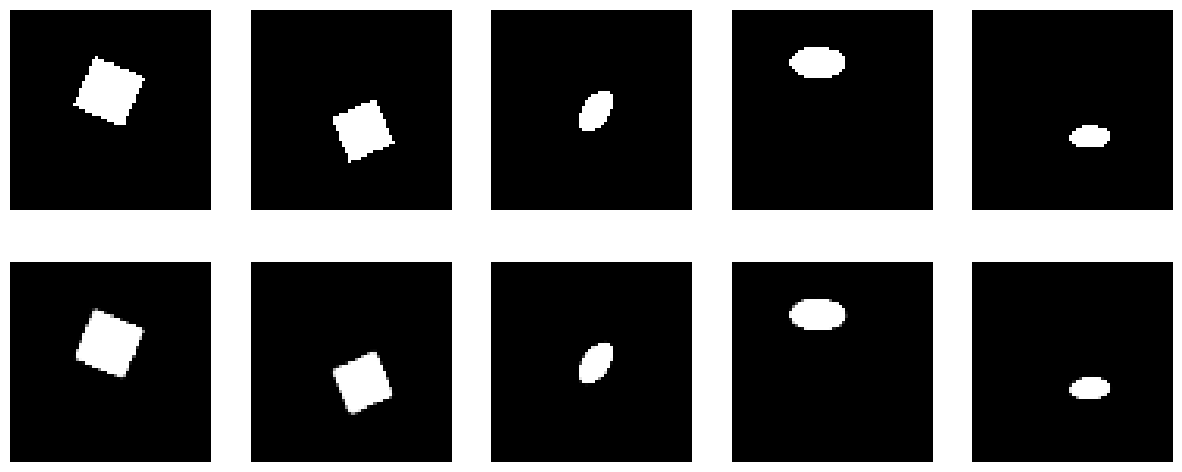

Extracting Factors and Latents: 100%|███████████████████████████████████████████| 11520/11520 [00:56<00:00, 205.57it/s]



Computing disentangelement scores for beta = 1:
Iteration 1:
MIG score: 0.1782
SAP score: 0.0608

Iteration 2:
MIG score: 0.1808
SAP score: 0.063

Iteration 3:
MIG score: 0.1808
SAP score: 0.0602

Iteration 4:
MIG score: 0.18
SAP score: 0.0608

Iteration 5:
MIG score: 0.1791
SAP score: 0.0603

Iteration 6:
MIG score: 0.1794
SAP score: 0.0627

Iteration 7:
MIG score: 0.1798
SAP score: 0.0622

Iteration 8:
MIG score: 0.1785
SAP score: 0.0606

Iteration 9:
MIG score: 0.1798
SAP score: 0.0634

Iteration 10:
MIG score: 0.1797
SAP score: 0.0631

Max MIG score is 0.1808 at iteration 2
Max MI matrix:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0318 0.055  0.0235 0.0494 0.0278 0.3223 0.1783 0.0173 0.042  0.167 ]
 [0.0183 0.0433 0.0228 0.0158 0.0159 0.025  0.7397 0.0155 0.0113 0.0182]
 [0.0495 0.0129 0.0184 0.0143 0.0368 0.0929 0.0077 0.0198 0.0178 0.0301]
 [0.2965 0.0225 0.1877 0.3239 0.2183 0.0211 0.0226 0.4845 0.1377 0.0078]
 [0.3824 0.0614 0.0847 0.036  0.42

Epoch 1/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:46<00:00, 69.17batch/s]


Epoch [1/80], Recon: 21.8247, KL: 18.6900, ELBO: 59.2047


Epoch 2/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:40<00:00, 71.96batch/s]


Epoch [2/80], Recon: 21.9980, KL: 18.5328, ELBO: 59.0637


Epoch 3/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:10<00:00, 88.30batch/s]


Epoch [3/80], Recon: 22.0932, KL: 18.4705, ELBO: 59.0341


Epoch 4/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.90batch/s]


Epoch [4/80], Recon: 22.1123, KL: 18.4270, ELBO: 58.9662


Epoch 5/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.21batch/s]


Epoch [5/80], Recon: 22.1088, KL: 18.3931, ELBO: 58.895


Epoch 6/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.75batch/s]


Epoch [6/80], Recon: 22.1211, KL: 18.3674, ELBO: 58.8559


Epoch 7/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.75batch/s]


Epoch [7/80], Recon: 22.1047, KL: 18.3443, ELBO: 58.7932


Epoch 8/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.27batch/s]


Epoch [8/80], Recon: 22.0685, KL: 18.3268, ELBO: 58.722


Epoch 9/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.96batch/s]


Epoch [9/80], Recon: 22.0482, KL: 18.3021, ELBO: 58.6524


Epoch 10/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.42batch/s]


Epoch [10/80], Recon: 22.0279, KL: 18.2909, ELBO: 58.6097


Epoch 11/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.81batch/s]


Epoch [11/80], Recon: 21.9656, KL: 18.2783, ELBO: 58.5222


Epoch 12/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.62batch/s]


Epoch [12/80], Recon: 21.9652, KL: 18.2653, ELBO: 58.4958


Epoch 13/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.68batch/s]


Epoch [13/80], Recon: 21.9605, KL: 18.2499, ELBO: 58.4604


Epoch 14/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.67batch/s]


Epoch [14/80], Recon: 21.8807, KL: 18.2390, ELBO: 58.3587


Epoch 15/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.68batch/s]


Epoch [15/80], Recon: 21.8809, KL: 18.2285, ELBO: 58.3379


Epoch 16/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.49batch/s]


Epoch [16/80], Recon: 21.8092, KL: 18.2196, ELBO: 58.2483


Epoch 17/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.03batch/s]


Epoch [17/80], Recon: 21.7869, KL: 18.2136, ELBO: 58.2142


Epoch 18/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.74batch/s]


Epoch [18/80], Recon: 21.7298, KL: 18.1959, ELBO: 58.1215


Epoch 19/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.00batch/s]


Epoch [19/80], Recon: 21.7156, KL: 18.1923, ELBO: 58.1003


Epoch 20/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.30batch/s]


Epoch [20/80], Recon: 21.6933, KL: 18.1887, ELBO: 58.0708


Epoch 21/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.84batch/s]


Epoch [21/80], Recon: 21.6251, KL: 18.1726, ELBO: 57.9703


Epoch 22/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.56batch/s]


Epoch [22/80], Recon: 21.5982, KL: 18.1685, ELBO: 57.9352


Epoch 23/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.69batch/s]


Epoch [23/80], Recon: 21.5441, KL: 18.1641, ELBO: 57.8724


Epoch 24/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.94batch/s]


Epoch [24/80], Recon: 21.5197, KL: 18.1585, ELBO: 57.8367


Epoch 25/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.53batch/s]


Epoch [25/80], Recon: 21.4606, KL: 18.1524, ELBO: 57.7653


Epoch 26/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.78batch/s]


Epoch [26/80], Recon: 21.4278, KL: 18.1424, ELBO: 57.7126


Epoch 27/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.36batch/s]


Epoch [27/80], Recon: 21.3944, KL: 18.1386, ELBO: 57.6716


Epoch 28/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.64batch/s]


Epoch [28/80], Recon: 21.3401, KL: 18.1230, ELBO: 57.5861


Epoch 29/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.70batch/s]


Epoch [29/80], Recon: 21.2965, KL: 18.1152, ELBO: 57.5269


Epoch 30/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.54batch/s]


Epoch [30/80], Recon: 21.2539, KL: 18.1142, ELBO: 57.4824


Epoch 31/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.47batch/s]


Epoch [31/80], Recon: 21.2144, KL: 18.1103, ELBO: 57.435


Epoch 32/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.52batch/s]


Epoch [32/80], Recon: 21.2016, KL: 18.1074, ELBO: 57.4164


Epoch 33/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.39batch/s]


Epoch [33/80], Recon: 21.1280, KL: 18.0979, ELBO: 57.3237


Epoch 34/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.65batch/s]


Epoch [34/80], Recon: 21.1081, KL: 18.0939, ELBO: 57.2959


Epoch 35/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.53batch/s]


Epoch [35/80], Recon: 21.0483, KL: 18.0916, ELBO: 57.2314


Epoch 36/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.33batch/s]


Epoch [36/80], Recon: 21.0417, KL: 18.0911, ELBO: 57.224


Epoch 37/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.14batch/s]


Epoch [37/80], Recon: 20.9753, KL: 18.0792, ELBO: 57.1337


Epoch 38/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.19batch/s]


Epoch [38/80], Recon: 20.9538, KL: 18.0793, ELBO: 57.1125


Epoch 39/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.82batch/s]


Epoch [39/80], Recon: 20.9078, KL: 18.0756, ELBO: 57.0591


Epoch 40/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.66batch/s]


Epoch [40/80], Recon: 20.8813, KL: 18.0687, ELBO: 57.0186


Epoch 41/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.29batch/s]


Epoch [41/80], Recon: 20.8373, KL: 18.0747, ELBO: 56.9868


Epoch 42/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.94batch/s]


Epoch [42/80], Recon: 20.7771, KL: 18.0599, ELBO: 56.8969


Epoch 43/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.74batch/s]


Epoch [43/80], Recon: 20.7706, KL: 18.0648, ELBO: 56.9002


Epoch 44/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.13batch/s]


Epoch [44/80], Recon: 20.7416, KL: 18.0642, ELBO: 56.87


Epoch 45/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.39batch/s]


Epoch [45/80], Recon: 20.6619, KL: 18.0617, ELBO: 56.7853


Epoch 46/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.15batch/s]


Epoch [46/80], Recon: 20.6541, KL: 18.0597, ELBO: 56.7734


Epoch 47/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.21batch/s]


Epoch [47/80], Recon: 20.6329, KL: 18.0586, ELBO: 56.7501


Epoch 48/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.50batch/s]


Epoch [48/80], Recon: 20.5809, KL: 18.0597, ELBO: 56.7004


Epoch 49/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.37batch/s]


Epoch [49/80], Recon: 20.5286, KL: 18.0506, ELBO: 56.6298


Epoch 50/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.22batch/s]


Epoch [50/80], Recon: 20.5288, KL: 18.0560, ELBO: 56.6408


Epoch 51/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.52batch/s]


Epoch [51/80], Recon: 20.4600, KL: 18.0429, ELBO: 56.5457


Epoch 52/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.47batch/s]


Epoch [52/80], Recon: 20.4291, KL: 18.0528, ELBO: 56.5348


Epoch 53/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.83batch/s]


Epoch [53/80], Recon: 20.3980, KL: 18.0426, ELBO: 56.4833


Epoch 54/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.31batch/s]


Epoch [54/80], Recon: 20.3894, KL: 18.0341, ELBO: 56.4576


Epoch 55/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.00batch/s]


Epoch [55/80], Recon: 20.4140, KL: 18.0423, ELBO: 56.4986


Epoch 56/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.87batch/s]


Epoch [56/80], Recon: 20.2880, KL: 18.0359, ELBO: 56.3597


Epoch 57/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.37batch/s]


Epoch [57/80], Recon: 20.2788, KL: 18.0430, ELBO: 56.3648


Epoch 58/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.59batch/s]


Epoch [58/80], Recon: 20.2410, KL: 18.0362, ELBO: 56.3133


Epoch 59/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.48batch/s]


Epoch [59/80], Recon: 20.1976, KL: 18.0226, ELBO: 56.2429


Epoch 60/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.68batch/s]


Epoch [60/80], Recon: 20.1670, KL: 18.0342, ELBO: 56.2355


Epoch 61/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.59batch/s]


Epoch [61/80], Recon: 20.1438, KL: 18.0370, ELBO: 56.2177


Epoch 62/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.76batch/s]


Epoch [62/80], Recon: 20.0991, KL: 18.0294, ELBO: 56.158


Epoch 63/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:55<00:00, 99.40batch/s]


Epoch [63/80], Recon: 20.0924, KL: 18.0314, ELBO: 56.1551


Epoch 64/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.36batch/s]


Epoch [64/80], Recon: 20.1241, KL: 18.0271, ELBO: 56.1783


Epoch 65/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.03batch/s]


Epoch [65/80], Recon: 19.9805, KL: 18.0304, ELBO: 56.0413


Epoch 66/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 99.11batch/s]


Epoch [66/80], Recon: 19.9855, KL: 18.0277, ELBO: 56.041

Visualizing reconstructions for beta = 2:


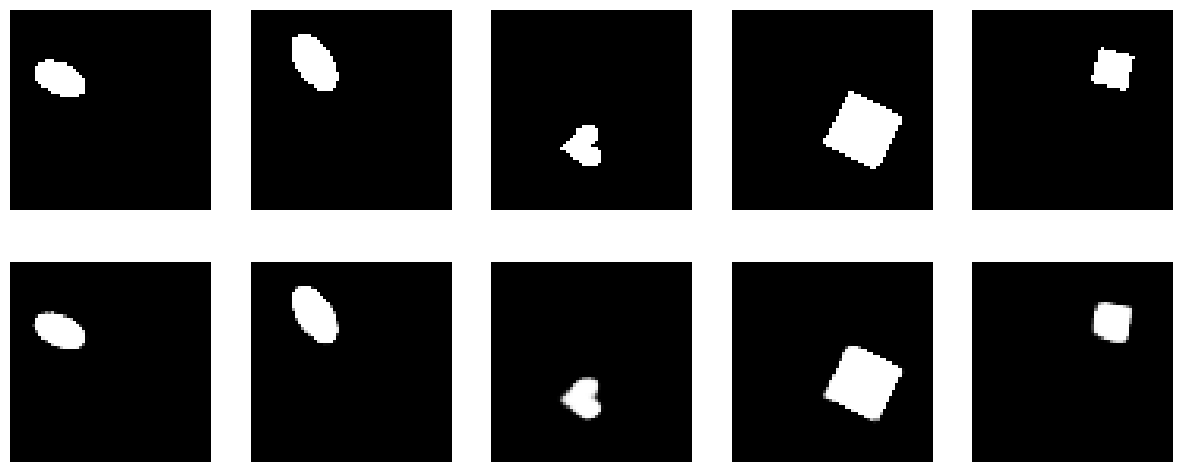

Extracting Factors and Latents: 100%|███████████████████████████████████████████| 11520/11520 [01:02<00:00, 184.68it/s]



Computing disentangelement scores for beta = 2:
Iteration 1:
MIG score: 0.2305
SAP score: 0.1031

Iteration 2:
MIG score: 0.2288
SAP score: 0.1067

Iteration 3:
MIG score: 0.2324
SAP score: 0.1042

Iteration 4:
MIG score: 0.2279
SAP score: 0.1041

Iteration 5:
MIG score: 0.2254
SAP score: 0.1061

Iteration 6:
MIG score: 0.2307
SAP score: 0.1059

Iteration 7:
MIG score: 0.2253
SAP score: 0.1048

Iteration 8:
MIG score: 0.2292
SAP score: 0.1037

Iteration 9:
MIG score: 0.2318
SAP score: 0.105

Iteration 10:
MIG score: 0.2316
SAP score: 0.1018

Max MIG score is 0.2324 at iteration 3
Max MI matrix:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0333 0.0496 0.0609 0.1314 0.0283 0.3511 0.3685 0.0219 0.0661 0.1915]
 [0.0056 0.0265 0.0171 0.029  0.0046 0.0226 1.1513 0.0041 0.0256 0.018 ]
 [0.0535 0.014  0.021  0.0118 0.0425 0.0973 0.009  0.0261 0.0191 0.028 ]
 [0.3013 0.0492 0.0208 0.0253 0.2255 0.0164 0.0137 0.4616 0.0649 0.0083]
 [0.3718 0.1059 0.0735 0.0762 0.

Epoch 1/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.71batch/s]


Epoch [1/80], Recon: 26.9980, KL: 15.9013, ELBO: 90.6031


Epoch 2/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:16<00:00, 84.47batch/s]


Epoch [2/80], Recon: 27.6440, KL: 15.6955, ELBO: 90.4261


Epoch 3/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:15<00:00, 85.20batch/s]


Epoch [3/80], Recon: 27.9336, KL: 15.6110, ELBO: 90.3776


Epoch 4/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:15<00:00, 84.80batch/s]


Epoch [4/80], Recon: 28.0705, KL: 15.5466, ELBO: 90.2568


Epoch 5/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:14<00:00, 85.77batch/s]


Epoch [5/80], Recon: 28.2279, KL: 15.5022, ELBO: 90.2366


Epoch 6/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:14<00:00, 85.47batch/s]


Epoch [6/80], Recon: 28.3169, KL: 15.4776, ELBO: 90.2273


Epoch 7/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:18<00:00, 83.35batch/s]


Epoch [7/80], Recon: 28.3830, KL: 15.4431, ELBO: 90.1552


Epoch 8/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:20<00:00, 81.93batch/s]


Epoch [8/80], Recon: 28.4695, KL: 15.4239, ELBO: 90.165


Epoch 9/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:18<00:00, 83.47batch/s]


Epoch [9/80], Recon: 28.4437, KL: 15.4014, ELBO: 90.0494


Epoch 10/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:22<00:00, 81.01batch/s]


Epoch [10/80], Recon: 28.5331, KL: 15.3946, ELBO: 90.1114


Epoch 11/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:21<00:00, 81.36batch/s]


Epoch [11/80], Recon: 28.5027, KL: 15.3723, ELBO: 89.992


Epoch 12/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:23<00:00, 80.23batch/s]


Epoch [12/80], Recon: 28.5441, KL: 15.3647, ELBO: 90.003


Epoch 13/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:22<00:00, 81.12batch/s]


Epoch [13/80], Recon: 28.5521, KL: 15.3518, ELBO: 89.9592


Epoch 14/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:24<00:00, 79.59batch/s]


Epoch [14/80], Recon: 28.6031, KL: 15.3550, ELBO: 90.0231


Epoch 15/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:23<00:00, 80.51batch/s]


Epoch [15/80], Recon: 28.5865, KL: 15.3259, ELBO: 89.8901


Epoch 16/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:22<00:00, 80.83batch/s]


Epoch [16/80], Recon: 28.5658, KL: 15.3270, ELBO: 89.8739


Epoch 17/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:21<00:00, 81.44batch/s]


Epoch [17/80], Recon: 28.5690, KL: 15.3222, ELBO: 89.8577


Epoch 18/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:23<00:00, 80.22batch/s]


Epoch [18/80], Recon: 28.5466, KL: 15.3066, ELBO: 89.7732


Epoch 19/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:22<00:00, 80.64batch/s]


Epoch [19/80], Recon: 28.5418, KL: 15.3030, ELBO: 89.7537


Epoch 20/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:23<00:00, 80.05batch/s]


Epoch [20/80], Recon: 28.5058, KL: 15.3005, ELBO: 89.7077


Epoch 21/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:11<00:00, 87.85batch/s]


Epoch [21/80], Recon: 28.6169, KL: 15.2873, ELBO: 89.766


Epoch 22/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.67batch/s]


Epoch [22/80], Recon: 28.5524, KL: 15.2863, ELBO: 89.6976


Epoch 23/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.40batch/s]


Epoch [23/80], Recon: 28.5579, KL: 15.2873, ELBO: 89.707


Epoch 24/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.00batch/s]


Epoch [24/80], Recon: 28.5369, KL: 15.2772, ELBO: 89.6458


Epoch 25/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.90batch/s]


Epoch [25/80], Recon: 28.5287, KL: 15.2749, ELBO: 89.6283


Epoch 26/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.66batch/s]


Epoch [26/80], Recon: 28.4920, KL: 15.2703, ELBO: 89.5732


Epoch 27/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.27batch/s]


Epoch [27/80], Recon: 28.4446, KL: 15.2663, ELBO: 89.5099


Epoch 28/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.94batch/s]


Epoch [28/80], Recon: 28.4586, KL: 15.2640, ELBO: 89.5147


Epoch 29/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.45batch/s]


Epoch [29/80], Recon: 28.4613, KL: 15.2575, ELBO: 89.4913


Epoch 30/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.59batch/s]


Epoch [30/80], Recon: 28.4221, KL: 15.2628, ELBO: 89.4734


Epoch 31/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.86batch/s]


Epoch [31/80], Recon: 28.3965, KL: 15.2536, ELBO: 89.4107


Epoch 32/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.20batch/s]


Epoch [32/80], Recon: 28.4097, KL: 15.2522, ELBO: 89.4184


Epoch 33/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.20batch/s]


Epoch [33/80], Recon: 28.3624, KL: 15.2511, ELBO: 89.3668


Epoch 34/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.53batch/s]


Epoch [34/80], Recon: 28.3357, KL: 15.2461, ELBO: 89.3201


Epoch 35/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.48batch/s]


Epoch [35/80], Recon: 28.3218, KL: 15.2482, ELBO: 89.3146


Epoch 36/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.27batch/s]


Epoch [36/80], Recon: 28.3447, KL: 15.2447, ELBO: 89.3234


Epoch 37/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.03batch/s]


Epoch [37/80], Recon: 28.3309, KL: 15.2423, ELBO: 89.3002


Epoch 38/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.89batch/s]


Epoch [38/80], Recon: 28.2274, KL: 15.2446, ELBO: 89.2056


Epoch 39/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.66batch/s]


Epoch [39/80], Recon: 28.3038, KL: 15.2462, ELBO: 89.2885


Epoch 40/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.39batch/s]


Epoch [40/80], Recon: 28.2968, KL: 15.2438, ELBO: 89.272


Epoch 41/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.85batch/s]


Epoch [41/80], Recon: 28.2449, KL: 15.2440, ELBO: 89.2211


Epoch 42/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.24batch/s]


Epoch [42/80], Recon: 28.2484, KL: 15.2312, ELBO: 89.1734


Epoch 43/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.89batch/s]


Epoch [43/80], Recon: 28.2484, KL: 15.2354, ELBO: 89.1902


Epoch 44/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.66batch/s]


Epoch [44/80], Recon: 28.1511, KL: 15.2321, ELBO: 89.0794


Epoch 45/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.79batch/s]


Epoch [45/80], Recon: 28.1419, KL: 15.2348, ELBO: 89.0809


Epoch 46/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.20batch/s]


Epoch [46/80], Recon: 28.0983, KL: 15.2308, ELBO: 89.0214


Epoch 47/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:56<00:00, 98.83batch/s]


Epoch [47/80], Recon: 28.0691, KL: 15.2377, ELBO: 89.0199


Epoch 48/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.26batch/s]


Epoch [48/80], Recon: 28.1511, KL: 15.2355, ELBO: 89.0932


Epoch 49/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.52batch/s]


Epoch [49/80], Recon: 28.0952, KL: 15.2300, ELBO: 89.0153


Epoch 50/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.72batch/s]


Epoch [50/80], Recon: 28.0919, KL: 15.2386, ELBO: 89.0463


Epoch 51/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.05batch/s]


Epoch [51/80], Recon: 28.0353, KL: 15.2292, ELBO: 88.952


Epoch 52/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.81batch/s]


Epoch [52/80], Recon: 28.0540, KL: 15.2233, ELBO: 88.9473


Epoch 53/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 92.95batch/s]


Epoch [53/80], Recon: 28.0672, KL: 15.2310, ELBO: 88.9913


Epoch 54/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.45batch/s]


Epoch [54/80], Recon: 27.9735, KL: 15.2238, ELBO: 88.8685


Epoch 55/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.70batch/s]


Epoch [55/80], Recon: 27.9247, KL: 15.2224, ELBO: 88.8143


Epoch 56/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.86batch/s]


Epoch [56/80], Recon: 28.0381, KL: 15.2251, ELBO: 88.9385


Epoch 57/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.15batch/s]


Epoch [57/80], Recon: 27.9261, KL: 15.2207, ELBO: 88.8089


Epoch 58/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.45batch/s]


Epoch [58/80], Recon: 27.9347, KL: 15.2228, ELBO: 88.8258


Epoch 59/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.12batch/s]


Epoch [59/80], Recon: 27.8981, KL: 15.2243, ELBO: 88.7954


Epoch 60/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.88batch/s]


Epoch [60/80], Recon: 27.8823, KL: 15.2250, ELBO: 88.7822


Epoch 61/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.70batch/s]


Epoch [61/80], Recon: 27.8713, KL: 15.2307, ELBO: 88.7941


Epoch 62/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.16batch/s]


Epoch [62/80], Recon: 27.9690, KL: 15.2282, ELBO: 88.8819


Epoch 63/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.52batch/s]


Epoch [63/80], Recon: 27.9135, KL: 15.2239, ELBO: 88.8092


Epoch 64/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.85batch/s]


Epoch [64/80], Recon: 27.9280, KL: 15.2271, ELBO: 88.8363


Epoch 65/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.46batch/s]


Epoch [65/80], Recon: 27.8152, KL: 15.2227, ELBO: 88.7061


Epoch 66/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.55batch/s]


Epoch [66/80], Recon: 27.8123, KL: 15.2181, ELBO: 88.6847


Epoch 67/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.26batch/s]


Epoch [67/80], Recon: 27.8031, KL: 15.2244, ELBO: 88.7009


Epoch 68/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.15batch/s]


Epoch [68/80], Recon: 27.7378, KL: 15.2169, ELBO: 88.6055


Epoch 69/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.23batch/s]


Epoch [69/80], Recon: 27.8267, KL: 15.2152, ELBO: 88.6875


Epoch 70/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.61batch/s]


Epoch [70/80], Recon: 27.7551, KL: 15.2256, ELBO: 88.6573


Epoch 71/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.84batch/s]


Epoch [71/80], Recon: 27.7041, KL: 15.2192, ELBO: 88.5809


Epoch 72/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.31batch/s]


Epoch [72/80], Recon: 27.7140, KL: 15.2238, ELBO: 88.6094


Epoch 73/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.79batch/s]


Epoch [73/80], Recon: 27.6958, KL: 15.2221, ELBO: 88.5842


Epoch 74/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 97.90batch/s]


Epoch [74/80], Recon: 27.8049, KL: 15.2263, ELBO: 88.7099


Epoch 75/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.66batch/s]


Epoch [75/80], Recon: 27.6611, KL: 15.2161, ELBO: 88.5254


Epoch 76/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.59batch/s]


Epoch [76/80], Recon: 27.6631, KL: 15.2079, ELBO: 88.4945


Epoch 77/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:57<00:00, 98.03batch/s]


Epoch [77/80], Recon: 27.7232, KL: 15.2119, ELBO: 88.571


Epoch 78/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.41batch/s]


Epoch [78/80], Recon: 27.5622, KL: 15.2139, ELBO: 88.4178


Epoch 79/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.83batch/s]


Epoch [79/80], Recon: 27.6224, KL: 15.2214, ELBO: 88.508


Epoch 80/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.39batch/s]


Epoch [80/80], Recon: 27.5488, KL: 15.2128, ELBO: 88.4002

Visualizing reconstructions for beta = 4:


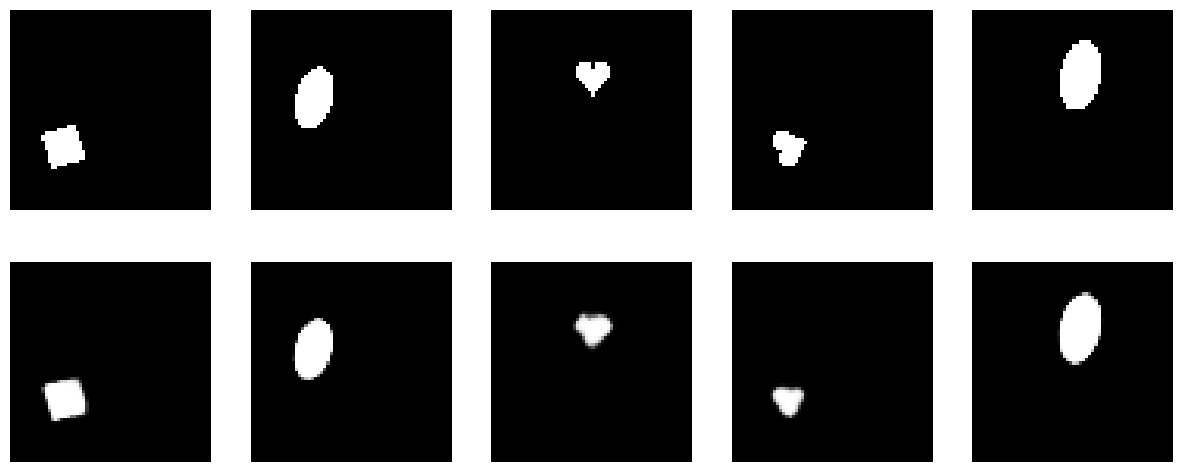

Extracting Factors and Latents: 100%|███████████████████████████████████████████| 11520/11520 [01:00<00:00, 191.89it/s]



Computing disentangelement scores for beta = 4:
Iteration 1:
MIG score: 0.2099
SAP score: 0.0868

Iteration 2:
MIG score: 0.2121
SAP score: 0.0878

Iteration 3:
MIG score: 0.2108
SAP score: 0.0876

Iteration 4:
MIG score: 0.2109
SAP score: 0.0884

Iteration 5:
MIG score: 0.2098
SAP score: 0.0894

Iteration 6:
MIG score: 0.2113
SAP score: 0.0889

Iteration 7:
MIG score: 0.211
SAP score: 0.0879

Iteration 8:
MIG score: 0.2099
SAP score: 0.0895

Iteration 9:
MIG score: 0.2104
SAP score: 0.0872

Iteration 10:
MIG score: 0.2095
SAP score: 0.088

Max MIG score is 0.2121 at iteration 2
Max MI matrix:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0353 0.0547 0.0473 0.0417 0.0272 0.3736 0.3072 0.0227 0.0221 0.201 ]
 [0.0033 0.0937 0.0381 0.0113 0.0028 0.037  1.06   0.0026 0.007  0.0272]
 [0.0551 0.0105 0.0155 0.01   0.0455 0.0962 0.0094 0.0291 0.0145 0.0238]
 [0.298  0.1216 0.0298 0.0311 0.2336 0.0099 0.0371 0.4556 0.1073 0.0097]
 [0.3738 0.0842 0.0357 0.0938 0.4

Epoch 1/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.49batch/s]


Epoch [1/80], Recon: 34.6173, KL: 13.9334, ELBO: 118.2178


Epoch 2/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.29batch/s]


Epoch [2/80], Recon: 35.6016, KL: 13.7765, ELBO: 118.2608


Epoch 3/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 96.98batch/s]


Epoch [3/80], Recon: 35.7457, KL: 13.7092, ELBO: 118.0007


Epoch 4/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.96batch/s]


Epoch [4/80], Recon: 36.0281, KL: 13.6766, ELBO: 118.0879


Epoch 5/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.06batch/s]


Epoch [5/80], Recon: 36.1330, KL: 13.6523, ELBO: 118.047


Epoch 6/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:58<00:00, 97.43batch/s]


Epoch [6/80], Recon: 36.3222, KL: 13.6181, ELBO: 118.0307


Epoch 7/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.17batch/s]


Epoch [7/80], Recon: 36.3532, KL: 13.5897, ELBO: 117.8914


Epoch 8/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.30batch/s]


Epoch [8/80], Recon: 36.4984, KL: 13.5687, ELBO: 117.9107


Epoch 9/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.30batch/s]


Epoch [9/80], Recon: 36.5873, KL: 13.5677, ELBO: 117.9933


Epoch 10/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:11<00:00, 87.60batch/s]


Epoch [10/80], Recon: 36.5934, KL: 13.5538, ELBO: 117.9163


Epoch 11/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.08batch/s]


Epoch [11/80], Recon: 36.7058, KL: 13.5473, ELBO: 117.9899


Epoch 12/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:13<00:00, 86.56batch/s]


Epoch [12/80], Recon: 36.7640, KL: 13.5210, ELBO: 117.8901


Epoch 13/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:20<00:00, 81.75batch/s]


Epoch [13/80], Recon: 36.8343, KL: 13.5117, ELBO: 117.9045


Epoch 14/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:12<00:00, 86.97batch/s]


Epoch [14/80], Recon: 36.7901, KL: 13.5128, ELBO: 117.8668


Epoch 15/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.89batch/s]


Epoch [15/80], Recon: 36.8182, KL: 13.4991, ELBO: 117.8128


Epoch 16/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.18batch/s]


Epoch [16/80], Recon: 36.8215, KL: 13.4959, ELBO: 117.7971


Epoch 17/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.81batch/s]


Epoch [17/80], Recon: 36.8162, KL: 13.4846, ELBO: 117.7241


Epoch 18/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.15batch/s]


Epoch [18/80], Recon: 36.9375, KL: 13.4828, ELBO: 117.834


Epoch 19/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.27batch/s]


Epoch [19/80], Recon: 36.9579, KL: 13.4735, ELBO: 117.799


Epoch 20/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.62batch/s]


Epoch [20/80], Recon: 36.9271, KL: 13.4628, ELBO: 117.704


Epoch 21/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.64batch/s]


Epoch [21/80], Recon: 36.9250, KL: 13.4637, ELBO: 117.7069


Epoch 22/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.33batch/s]


Epoch [22/80], Recon: 37.0084, KL: 13.4520, ELBO: 117.7206


Epoch 23/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.18batch/s]


Epoch [23/80], Recon: 36.9966, KL: 13.4577, ELBO: 117.743


Epoch 24/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:11<00:00, 87.41batch/s]


Epoch [24/80], Recon: 37.0271, KL: 13.4484, ELBO: 117.7173


Epoch 25/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:09<00:00, 88.86batch/s]


Epoch [25/80], Recon: 36.9762, KL: 13.4340, ELBO: 117.5799


Epoch 26/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:08<00:00, 89.46batch/s]


Epoch [26/80], Recon: 37.1133, KL: 13.4385, ELBO: 117.7445


Epoch 27/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.42batch/s]


Epoch [27/80], Recon: 37.0655, KL: 13.4322, ELBO: 117.6588


Epoch 28/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.33batch/s]


Epoch [28/80], Recon: 37.1024, KL: 13.4366, ELBO: 117.7221


Epoch 29/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.78batch/s]


Epoch [29/80], Recon: 37.0408, KL: 13.4304, ELBO: 117.6233


Epoch 30/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.36batch/s]


Epoch [30/80], Recon: 37.1138, KL: 13.4278, ELBO: 117.6808


Epoch 31/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:08<00:00, 89.32batch/s]


Epoch [31/80], Recon: 37.0358, KL: 13.4208, ELBO: 117.5605


Epoch 32/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.46batch/s]


Epoch [32/80], Recon: 36.9822, KL: 13.4198, ELBO: 117.5007


Epoch 33/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.41batch/s]


Epoch [33/80], Recon: 37.0364, KL: 13.4182, ELBO: 117.5456


Epoch 34/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.92batch/s]


Epoch [34/80], Recon: 37.1490, KL: 13.4068, ELBO: 117.59


Epoch 35/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.58batch/s]


Epoch [35/80], Recon: 37.2556, KL: 13.4070, ELBO: 117.6978


Epoch 36/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.40batch/s]


Epoch [36/80], Recon: 37.1173, KL: 13.4113, ELBO: 117.5853


Epoch 37/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.16batch/s]


Epoch [37/80], Recon: 37.1188, KL: 13.4025, ELBO: 117.5337


Epoch 38/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.76batch/s]


Epoch [38/80], Recon: 37.1690, KL: 13.4010, ELBO: 117.575


Epoch 39/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.79batch/s]


Epoch [39/80], Recon: 37.1155, KL: 13.3971, ELBO: 117.4984


Epoch 40/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.88batch/s]


Epoch [40/80], Recon: 37.2557, KL: 13.3952, ELBO: 117.6268


Epoch 41/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.95batch/s]


Epoch [41/80], Recon: 37.0990, KL: 13.3989, ELBO: 117.4925


Epoch 42/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.40batch/s]


Epoch [42/80], Recon: 37.0200, KL: 13.3933, ELBO: 117.3797


Epoch 43/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.80batch/s]


Epoch [43/80], Recon: 37.1583, KL: 13.3964, ELBO: 117.5368


Epoch 44/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.66batch/s]


Epoch [44/80], Recon: 37.0583, KL: 13.3830, ELBO: 117.3566


Epoch 45/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.80batch/s]


Epoch [45/80], Recon: 37.0507, KL: 13.3795, ELBO: 117.3276


Epoch 46/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.07batch/s]


Epoch [46/80], Recon: 37.1233, KL: 13.3962, ELBO: 117.5005


Epoch 47/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.17batch/s]


Epoch [47/80], Recon: 37.1925, KL: 13.3863, ELBO: 117.51


Epoch 48/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.44batch/s]


Epoch [48/80], Recon: 37.0999, KL: 13.3830, ELBO: 117.3981


Epoch 49/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.53batch/s]


Epoch [49/80], Recon: 37.1686, KL: 13.3784, ELBO: 117.439


Epoch 50/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.45batch/s]


Epoch [50/80], Recon: 37.1104, KL: 13.3915, ELBO: 117.4594


Epoch 51/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.60batch/s]


Epoch [51/80], Recon: 37.1438, KL: 13.3778, ELBO: 117.4109


Epoch 52/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.59batch/s]


Epoch [52/80], Recon: 37.0694, KL: 13.3741, ELBO: 117.3139


Epoch 53/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.80batch/s]


Epoch [53/80], Recon: 37.0417, KL: 13.3826, ELBO: 117.3374


Epoch 54/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 92.95batch/s]


Epoch [54/80], Recon: 37.1618, KL: 13.3648, ELBO: 117.3503


Epoch 55/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:07<00:00, 90.70batch/s]


Epoch [55/80], Recon: 36.9836, KL: 13.3766, ELBO: 117.2429


Epoch 56/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.28batch/s]


Epoch [56/80], Recon: 37.3117, KL: 13.3693, ELBO: 117.5275


Epoch 57/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.45batch/s]


Epoch [57/80], Recon: 37.0005, KL: 13.3660, ELBO: 117.1965


Epoch 58/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.95batch/s]


Epoch [58/80], Recon: 37.1065, KL: 13.3644, ELBO: 117.2927


Epoch 59/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.74batch/s]


Epoch [59/80], Recon: 37.0474, KL: 13.3667, ELBO: 117.2477


Epoch 60/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.21batch/s]


Epoch [60/80], Recon: 37.0697, KL: 13.3715, ELBO: 117.2984


Epoch 61/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.20batch/s]


Epoch [61/80], Recon: 37.0540, KL: 13.3636, ELBO: 117.2358


Epoch 62/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.10batch/s]


Epoch [62/80], Recon: 37.1211, KL: 13.3735, ELBO: 117.3619


Epoch 63/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.71batch/s]


Epoch [63/80], Recon: 36.9582, KL: 13.3666, ELBO: 117.1579


Epoch 64/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.84batch/s]


Epoch [64/80], Recon: 37.2102, KL: 13.3599, ELBO: 117.3694


Epoch 65/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.29batch/s]


Epoch [65/80], Recon: 36.9975, KL: 13.3554, ELBO: 117.1301


Epoch 66/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.95batch/s]


Epoch [66/80], Recon: 37.0849, KL: 13.3621, ELBO: 117.2574


Epoch 67/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.94batch/s]


Epoch [67/80], Recon: 37.0689, KL: 13.3602, ELBO: 117.2302


Epoch 68/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.30batch/s]


Epoch [68/80], Recon: 37.0562, KL: 13.3597, ELBO: 117.2145


Epoch 69/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.16batch/s]


Epoch [69/80], Recon: 37.0709, KL: 13.3537, ELBO: 117.1931


Epoch 70/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:07<00:00, 90.25batch/s]


Epoch [70/80], Recon: 36.9825, KL: 13.3582, ELBO: 117.1319


Epoch 71/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.67batch/s]


Epoch [71/80], Recon: 36.9839, KL: 13.3544, ELBO: 117.1105


Epoch 72/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.18batch/s]


Epoch [72/80], Recon: 36.9781, KL: 13.3616, ELBO: 117.1474


Epoch 73/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.10batch/s]


Epoch [73/80], Recon: 37.0894, KL: 13.3563, ELBO: 117.2274


Epoch 74/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.57batch/s]


Epoch [74/80], Recon: 37.0360, KL: 13.3535, ELBO: 117.1572


Epoch 75/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.41batch/s]


Epoch [75/80], Recon: 37.0085, KL: 13.3576, ELBO: 117.1543


Epoch 76/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.63batch/s]


Epoch [76/80], Recon: 37.0127, KL: 13.3577, ELBO: 117.1586


Epoch 77/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.59batch/s]


Epoch [77/80], Recon: 37.0184, KL: 13.3553, ELBO: 117.1502


Epoch 78/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.77batch/s]


Epoch [78/80], Recon: 37.0145, KL: 13.3571, ELBO: 117.1571


Epoch 79/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.83batch/s]


Epoch [79/80], Recon: 37.0181, KL: 13.3478, ELBO: 117.1047


Epoch 80/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.39batch/s]


Epoch [80/80], Recon: 36.9344, KL: 13.3475, ELBO: 117.0191

Visualizing reconstructions for beta = 6:


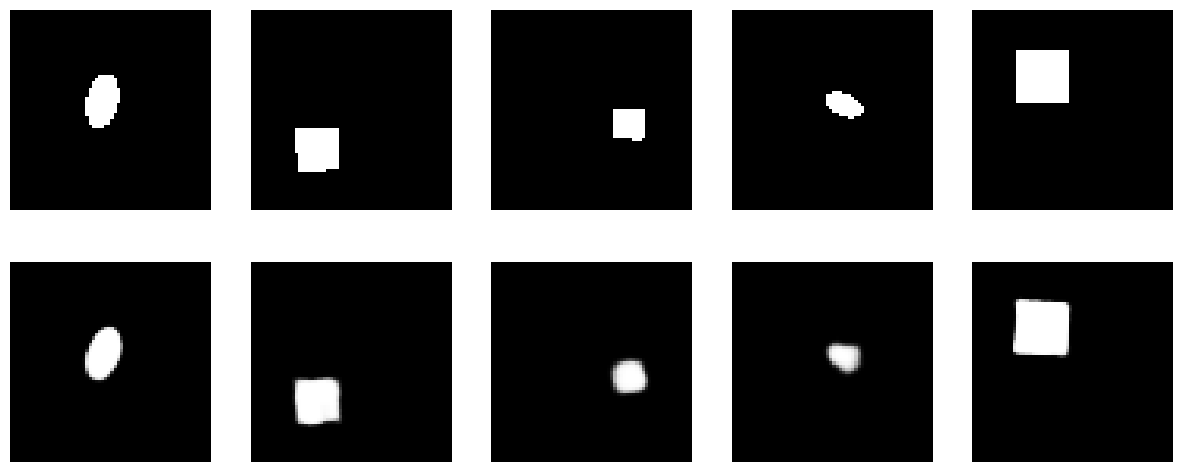

Extracting Factors and Latents: 100%|███████████████████████████████████████████| 11520/11520 [00:57<00:00, 199.72it/s]



Computing disentangelement scores for beta = 6:
Iteration 1:
MIG score: 0.2108
SAP score: 0.0976

Iteration 2:
MIG score: 0.21
SAP score: 0.0952

Iteration 3:
MIG score: 0.2166
SAP score: 0.0968

Iteration 4:
MIG score: 0.1975
SAP score: 0.0957

Iteration 5:
MIG score: 0.2087
SAP score: 0.0954

Iteration 6:
MIG score: 0.2166
SAP score: 0.0968

Iteration 7:
MIG score: 0.2177
SAP score: 0.0995

Iteration 8:
MIG score: 0.203
SAP score: 0.0961

Iteration 9:
MIG score: 0.2103
SAP score: 0.096

Iteration 10:
MIG score: 0.2099
SAP score: 0.0965

Max MIG score is 0.2177 at iteration 7
Max MI matrix:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0378 0.0798 0.0435 0.1268 0.0285 0.3606 0.4415 0.0259 0.0236 0.1854]
 [0.0061 0.0113 0.0483 0.0166 0.0035 0.0541 1.1455 0.0036 0.1537 0.053 ]
 [0.0544 0.0104 0.0107 0.0126 0.0426 0.0978 0.0118 0.0281 0.0068 0.0215]
 [0.285  0.0312 0.0454 0.0635 0.2417 0.0085 0.0136 0.4634 0.0146 0.0107]
 [0.3882 0.032  0.0174 0.0119 0.400

Epoch 1/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.36batch/s]


Epoch [1/80], Recon: 44.6959, KL: 12.3233, ELBO: 143.2827


Epoch 2/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.85batch/s]


Epoch [2/80], Recon: 45.8061, KL: 12.1701, ELBO: 143.1671


Epoch 3/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.55batch/s]


Epoch [3/80], Recon: 46.2151, KL: 12.1130, ELBO: 143.1194


Epoch 4/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.34batch/s]


Epoch [4/80], Recon: 46.5723, KL: 12.0553, ELBO: 143.0149


Epoch 5/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.37batch/s]


Epoch [5/80], Recon: 46.8135, KL: 12.0245, ELBO: 143.0097


Epoch 6/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.33batch/s]


Epoch [6/80], Recon: 47.1159, KL: 11.9968, ELBO: 143.0904


Epoch 7/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.41batch/s]


Epoch [7/80], Recon: 47.2210, KL: 11.9707, ELBO: 142.9864


Epoch 8/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [01:59<00:00, 96.10batch/s]


Epoch [8/80], Recon: 47.3867, KL: 11.9564, ELBO: 143.0377


Epoch 9/80: 100%|█████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 92.01batch/s]


Epoch [9/80], Recon: 47.5164, KL: 11.9347, ELBO: 142.9937


Epoch 10/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.49batch/s]


Epoch [10/80], Recon: 47.5317, KL: 11.9260, ELBO: 142.9397


Epoch 11/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.81batch/s]


Epoch [11/80], Recon: 47.7273, KL: 11.9139, ELBO: 143.0384


Epoch 12/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.73batch/s]


Epoch [12/80], Recon: 47.7293, KL: 11.9041, ELBO: 142.9619


Epoch 13/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.80batch/s]


Epoch [13/80], Recon: 47.7393, KL: 11.8964, ELBO: 142.9108


Epoch 14/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:09<00:00, 88.91batch/s]


Epoch [14/80], Recon: 47.9282, KL: 11.8759, ELBO: 142.9353


Epoch 15/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.34batch/s]


Epoch [15/80], Recon: 47.8261, KL: 11.8643, ELBO: 142.7405


Epoch 16/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.70batch/s]


Epoch [16/80], Recon: 47.9673, KL: 11.8534, ELBO: 142.7948


Epoch 17/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.71batch/s]


Epoch [17/80], Recon: 48.0289, KL: 11.8477, ELBO: 142.8104


Epoch 18/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.27batch/s]


Epoch [18/80], Recon: 48.0939, KL: 11.8471, ELBO: 142.8709


Epoch 19/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.34batch/s]


Epoch [19/80], Recon: 48.0121, KL: 11.8472, ELBO: 142.7894


Epoch 20/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.70batch/s]


Epoch [20/80], Recon: 48.1619, KL: 11.8393, ELBO: 142.8765


Epoch 21/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.37batch/s]


Epoch [21/80], Recon: 48.2593, KL: 11.8317, ELBO: 142.9129


Epoch 22/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.23batch/s]


Epoch [22/80], Recon: 48.1225, KL: 11.8264, ELBO: 142.7338


Epoch 23/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.72batch/s]


Epoch [23/80], Recon: 48.4140, KL: 11.8140, ELBO: 142.926


Epoch 24/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.87batch/s]


Epoch [24/80], Recon: 48.3136, KL: 11.8109, ELBO: 142.8005


Epoch 25/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.57batch/s]


Epoch [25/80], Recon: 48.2574, KL: 11.8053, ELBO: 142.6995


Epoch 26/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.76batch/s]


Epoch [26/80], Recon: 48.4720, KL: 11.8033, ELBO: 142.8988


Epoch 27/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.44batch/s]


Epoch [27/80], Recon: 48.2638, KL: 11.7994, ELBO: 142.6591


Epoch 28/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.33batch/s]


Epoch [28/80], Recon: 48.3283, KL: 11.8007, ELBO: 142.7341


Epoch 29/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:07<00:00, 90.33batch/s]


Epoch [29/80], Recon: 48.3544, KL: 11.8004, ELBO: 142.7575


Epoch 30/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.16batch/s]


Epoch [30/80], Recon: 48.4174, KL: 11.7879, ELBO: 142.7206


Epoch 31/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.95batch/s]


Epoch [31/80], Recon: 48.3328, KL: 11.7850, ELBO: 142.6126


Epoch 32/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 92.01batch/s]


Epoch [32/80], Recon: 48.2514, KL: 11.7900, ELBO: 142.5717


Epoch 33/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.95batch/s]


Epoch [33/80], Recon: 48.4063, KL: 11.7886, ELBO: 142.7151


Epoch 34/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.26batch/s]


Epoch [34/80], Recon: 48.5059, KL: 11.7789, ELBO: 142.7373


Epoch 35/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.23batch/s]


Epoch [35/80], Recon: 48.4156, KL: 11.7814, ELBO: 142.6664


Epoch 36/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.53batch/s]


Epoch [36/80], Recon: 48.4043, KL: 11.7752, ELBO: 142.6061


Epoch 37/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.65batch/s]


Epoch [37/80], Recon: 48.5937, KL: 11.7769, ELBO: 142.8086


Epoch 38/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.77batch/s]


Epoch [38/80], Recon: 48.5395, KL: 11.7714, ELBO: 142.7105


Epoch 39/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.61batch/s]


Epoch [39/80], Recon: 48.4398, KL: 11.7714, ELBO: 142.6114


Epoch 40/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.98batch/s]


Epoch [40/80], Recon: 48.5667, KL: 11.7663, ELBO: 142.6975


Epoch 41/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.09batch/s]


Epoch [41/80], Recon: 48.4533, KL: 11.7597, ELBO: 142.5307


Epoch 42/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 95.13batch/s]


Epoch [42/80], Recon: 48.4705, KL: 11.7642, ELBO: 142.5845


Epoch 43/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:08<00:00, 89.56batch/s]


Epoch [43/80], Recon: 48.4611, KL: 11.7713, ELBO: 142.6314


Epoch 44/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.34batch/s]


Epoch [44/80], Recon: 48.4052, KL: 11.7583, ELBO: 142.4716


Epoch 45/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.05batch/s]


Epoch [45/80], Recon: 48.5870, KL: 11.7584, ELBO: 142.6545


Epoch 46/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.65batch/s]


Epoch [46/80], Recon: 48.5519, KL: 11.7585, ELBO: 142.62


Epoch 47/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.78batch/s]


Epoch [47/80], Recon: 48.4331, KL: 11.7535, ELBO: 142.4614


Epoch 48/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.71batch/s]


Epoch [48/80], Recon: 48.5456, KL: 11.7541, ELBO: 142.5783


Epoch 49/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.82batch/s]


Epoch [49/80], Recon: 48.5968, KL: 11.7568, ELBO: 142.651


Epoch 50/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.33batch/s]


Epoch [50/80], Recon: 48.3717, KL: 11.7597, ELBO: 142.4497


Epoch 51/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.66batch/s]


Epoch [51/80], Recon: 48.6428, KL: 11.7416, ELBO: 142.5752


Epoch 52/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.90batch/s]


Epoch [52/80], Recon: 48.5392, KL: 11.7481, ELBO: 142.5239


Epoch 53/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.71batch/s]


Epoch [53/80], Recon: 48.5742, KL: 11.7495, ELBO: 142.5701


Epoch 54/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.81batch/s]


Epoch [54/80], Recon: 48.5355, KL: 11.7436, ELBO: 142.4846


Epoch 55/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:07<00:00, 90.40batch/s]


Epoch [55/80], Recon: 48.5437, KL: 11.7486, ELBO: 142.5329


Epoch 56/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.95batch/s]


Epoch [56/80], Recon: 48.5606, KL: 11.7514, ELBO: 142.5718


Epoch 57/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.23batch/s]


Epoch [57/80], Recon: 48.7357, KL: 11.7376, ELBO: 142.6368


Epoch 58/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:08<00:00, 89.49batch/s]


Epoch [58/80], Recon: 48.4430, KL: 11.7472, ELBO: 142.421


Epoch 59/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.86batch/s]


Epoch [59/80], Recon: 48.4444, KL: 11.7447, ELBO: 142.4023


Epoch 60/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:07<00:00, 90.08batch/s]


Epoch [60/80], Recon: 48.4589, KL: 11.7403, ELBO: 142.3816


Epoch 61/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:03<00:00, 93.19batch/s]


Epoch [61/80], Recon: 48.4496, KL: 11.7387, ELBO: 142.3591


Epoch 62/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 92.14batch/s]


Epoch [62/80], Recon: 48.6745, KL: 11.7352, ELBO: 142.5565


Epoch 63/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.02batch/s]


Epoch [63/80], Recon: 48.4650, KL: 11.7360, ELBO: 142.3532


Epoch 64/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:01<00:00, 94.52batch/s]


Epoch [64/80], Recon: 48.4995, KL: 11.7408, ELBO: 142.4261


Epoch 65/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.32batch/s]


Epoch [65/80], Recon: 48.4068, KL: 11.7410, ELBO: 142.3349


Epoch 66/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.32batch/s]


Epoch [66/80], Recon: 48.4144, KL: 11.7438, ELBO: 142.3651


Epoch 67/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.23batch/s]


Epoch [67/80], Recon: 48.4801, KL: 11.7343, ELBO: 142.3546


Epoch 68/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.80batch/s]


Epoch [68/80], Recon: 48.4717, KL: 11.7368, ELBO: 142.3665


Epoch 69/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.70batch/s]


Epoch [69/80], Recon: 48.6124, KL: 11.7304, ELBO: 142.4553


Epoch 70/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 90.96batch/s]


Epoch [70/80], Recon: 48.6439, KL: 11.7292, ELBO: 142.4777


Epoch 71/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.22batch/s]


Epoch [71/80], Recon: 48.5888, KL: 11.7266, ELBO: 142.4014


Epoch 72/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:09<00:00, 89.03batch/s]


Epoch [72/80], Recon: 48.4793, KL: 11.7385, ELBO: 142.3875


Epoch 73/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.81batch/s]


Epoch [73/80], Recon: 48.5243, KL: 11.7351, ELBO: 142.405


Epoch 74/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:06<00:00, 91.11batch/s]


Epoch [74/80], Recon: 48.5766, KL: 11.7293, ELBO: 142.4108


Epoch 75/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 93.72batch/s]


Epoch [75/80], Recon: 48.5621, KL: 11.7243, ELBO: 142.3568


Epoch 76/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:02<00:00, 94.16batch/s]


Epoch [76/80], Recon: 48.4893, KL: 11.7349, ELBO: 142.3685


Epoch 77/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:05<00:00, 91.48batch/s]


Epoch [77/80], Recon: 48.4570, KL: 11.7322, ELBO: 142.3148


Epoch 78/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:00<00:00, 95.43batch/s]


Epoch [78/80], Recon: 48.5634, KL: 11.7233, ELBO: 142.3501


Epoch 79/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.50batch/s]


Epoch [79/80], Recon: 48.4607, KL: 11.7264, ELBO: 142.2719


Epoch 80/80: 100%|████████████████████████████████████████████████████████████| 11520/11520 [02:04<00:00, 92.52batch/s]


Epoch [80/80], Recon: 48.5391, KL: 11.7252, ELBO: 142.3411

Visualizing reconstructions for beta = 8:


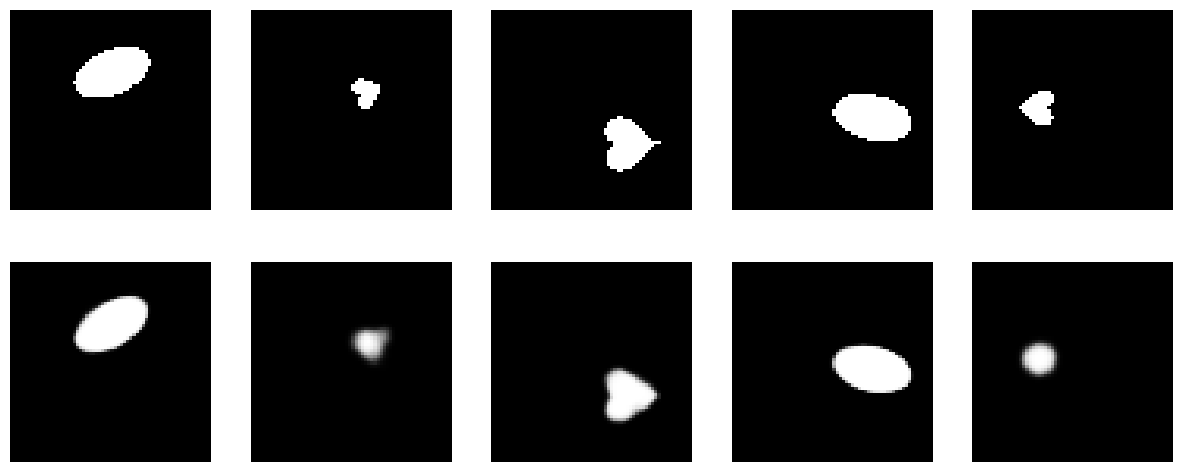

Extracting Factors and Latents: 100%|███████████████████████████████████████████| 11520/11520 [00:57<00:00, 200.33it/s]



Computing disentangelement scores for beta = 8:
Iteration 1:
MIG score: 0.2174
SAP score: 0.0982

Iteration 2:
MIG score: 0.2172
SAP score: 0.097

Iteration 3:
MIG score: 0.2141
SAP score: 0.0982

Iteration 4:
MIG score: 0.2101
SAP score: 0.0977

Iteration 5:
MIG score: 0.2128
SAP score: 0.0989

Iteration 6:
MIG score: 0.2167
SAP score: 0.097

Iteration 7:
MIG score: 0.2122
SAP score: 0.0998

Iteration 8:
MIG score: 0.2177
SAP score: 0.0993

Iteration 9:
MIG score: 0.2113
SAP score: 0.0976

Iteration 10:
MIG score: 0.2203
SAP score: 0.0986

Max MIG score is 0.2203 at iteration 10
Max MI matrix:
[[0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0391 0.022  0.0601 0.0446 0.0282 0.3182 0.3998 0.0259 0.0373 0.135 ]
 [0.0094 0.0322 0.0165 0.0291 0.0071 0.1162 1.1056 0.0045 0.0246 0.1137]
 [0.0522 0.0159 0.0222 0.0128 0.0364 0.0918 0.011  0.0246 0.0116 0.0189]
 [0.2715 0.0636 0.0954 0.0287 0.2486 0.0064 0.0137 0.4753 0.0525 0.013 ]
 [0.4008 0.0758 0.0576 0.0596 0.

In [8]:
# Train the beta-VAE
all_losses = []
recon_losses = []
kl_losses = []
all_mig_scores = []
all_sap_scores = []

for beta in beta_values:
    print(colored('\nTraining with beta = {}:'.format(beta), 'red', attrs=['bold']))
    recon, kl, elbo = train_vae(model, data_loader, optimizer, criterion, beta)
    all_losses.append(elbo)
    recon_losses.append(recon)
    kl_losses.append(kl)

    # Visualize reconstructions
    print(colored('\nVisualizing reconstructions for beta = {}:'.format(beta), 'blue', attrs=['bold']))
    visualize_reconstructions(model, data_loader, 5)

    # Extract all factors and latent representations
    all_factor_values, all_factor_classes, all_mu = get_factors_latents(model, data_loader)

    # Compute MIG and SAP scores
    print(colored('\nComputing disentangelement scores for beta = {}:'.format(beta), 'blue', attrs=['bold']))

    mig_scores_beta = []
    sap_scores_beta = []
    mi_matrices_beta = []
    min_mig_score = 1
    max_mig_score = 0
    min_idx = 0
    max_idx = 0
    for iter in range(NUM_ITERS):
        print(colored('Iteration {}:'.format(iter+1), attrs=['bold']))
        mig_score, sap_score, mi_matrix = compute_disentangelement_scores(all_factor_classes, all_mu)
        mig_scores_beta.append(mig_score)
        sap_scores_beta.append(sap_score)
        mi_matrices_beta.append(mi_matrix)

        if mig_score < min_mig_score:
            min_mig_score = mig_score
            min_idx = iter
        if mig_score > max_mig_score:
            max_mig_score = mig_score
            max_idx = iter

    print('Max MIG score is {} at iteration {}'.format(max_mig_score, max_idx+1))
    print('Max MI matrix:\n{}'.format(mi_matrices_beta[max_idx]))
    print('\nMin MIG score is {} at iteration {}'.format(min_mig_score, min_idx+1))
    print('Min MI matrix:\n{}'.format(mi_matrices_beta[min_idx]))
        
    all_mig_scores.append(mig_scores_beta)
    all_sap_scores.append(sap_scores_beta)

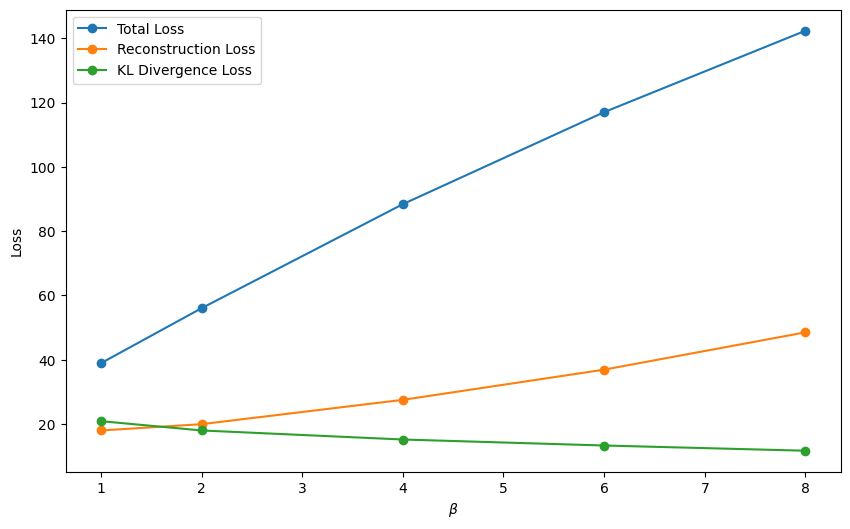

In [9]:
# Plot of losses vs beta values
plt.figure(figsize=(10, 6))
plt.plot(beta_values, all_losses, label='Total Loss', marker='o')
plt.plot(beta_values, recon_losses, label='Reconstruction Loss', marker='o')
plt.plot(beta_values, kl_losses, label='KL Divergence Loss', marker='o')
plt.xlabel(r'$\beta$')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.show()

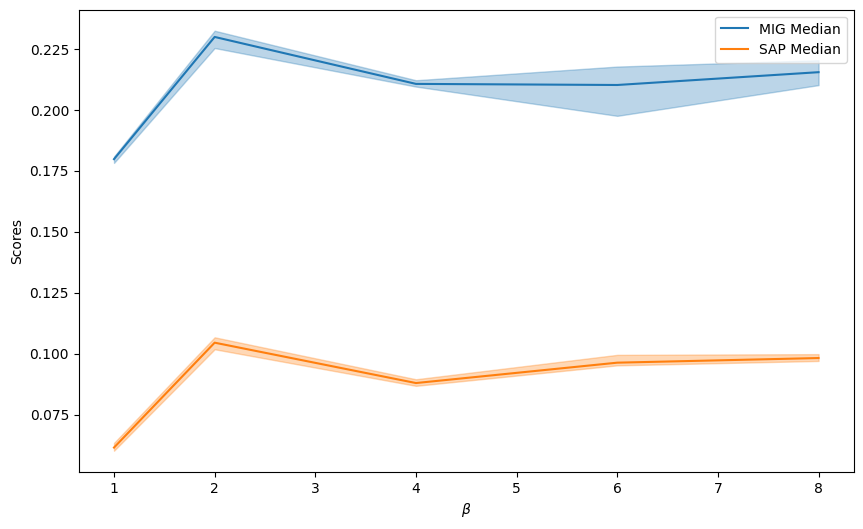

In [10]:
# Distribution of MIG and SAP scores for each beta value
# Compute median, min, and max values for each beta
mig_medians = np.median(all_mig_scores, axis=1)
mig_min = np.min(all_mig_scores, axis=1)
mig_max = np.max(all_mig_scores, axis=1)

sap_medians = np.median(all_sap_scores, axis=1)
sap_min = np.min(all_sap_scores, axis=1)
sap_max = np.max(all_sap_scores, axis=1)

# Create line plots with shaded regions for MIG and SAP scores
plt.figure(figsize=(10, 6))

plt.plot(beta_values, mig_medians, color='#1f77b4', label='MIG Median')  # Blue
plt.fill_between(beta_values, mig_min, mig_max, color='#1f77b4', alpha=0.3)

plt.plot(beta_values, sap_medians, color='#ff7f0e', label='SAP Median')  # Orange
plt.fill_between(beta_values, sap_min, sap_max, color='#ff7f0e', alpha=0.3)

plt.xlabel(r'$\beta$')
plt.ylabel('Scores')
plt.legend(loc='best')
plt.show()
